## Deep Q-Learning  
During class, we have learnt reinforcement learning. In this assignment, you need to design a Deep Q-Learning network to play the *CartPole* game. Our experiment consists of three parts:

1. Introduction to CartPole game
2. Implementation of Deep Q-Learning network
3. Analytical questions.

First, let us import some necessary packages.

In [1]:
%matplotlib inline
from IPython import display
import random
import numpy as np
import matplotlib.pyplot as plt

### Introduction to CartPole
[CartPole](https://gym.openai.com/envs/CartPole-v1/) is a classical environment from [gym](https://gym.openai.com/) package that is designed by [OpenAI](https://openai.com/). In CartPole environment, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum will fall over due to gravity if the cart doesn't move.

![](./fig.jpg)

Our goal is to balance the pole on the cart. We have:
- Continuous state space: $(x, \theta, \dot{x}, \dot{\theta})$ 
- Discrete action space: force $F\in\{0, 1\}$, $0$ for left force, $1$ for right force
- Reward: $+1$ if the pole is upright, $-10$ if the pole is more than $15$ degrees from vertical, or the cart moves more than $2.4$ units from the center.

To run CartPole, you need to install the `gym` package:
```py
pip install gym
pip install pyglet
```
Then import `gym` packages into our environment.

In [2]:
import gym

### Implementation of Deep Q-Learning

Give state space $S$, action space $A$, and policy $\pi$, the Q-value function $Q^\pi(s, a)$ is defined as the expected payoff if we take action $a\in A$ at state $s \in S$ and follow $\pi$:
$$
Q^{\pi}(s, a)=\mathbb{E}\left[\sum_{t \geq 0} \gamma^{t} r_{t} \mid s_{0}=s, a_{0}=a, \pi\right],
$$
where $\gamma$ is the discount factor, $r_t$ is the reward at time step $t$. So the the optimal Q-value function is 

$$
\begin{aligned}
Q^{*}(s, a)&=\max _{\pi} Q^{\pi}(s, a)=\max _{\pi} \mathbb{E}\left[\sum_{t \geq 0} \gamma^{t} r_{t} \mid s_{0}=s, a_{0}=a, \pi\right]\\&=\mathbb{E}_{s^{\prime} \sim \mathcal{E}}\left[r+\gamma \max _{a^{\prime}} Q^{*}\left(s^{\prime}, a^{\prime}\right) \mid s_{0}=s, a_{0}=a\right].
\end{aligned}
$$

In deep Q-learning, we use a neural network $Q_{\theta}$ to approximate $Q^{*}(s, a)$. Basically, the process can be described in following way:

When we apply action $a_t$ at state $s_t$, the environment gives a feedback that consists of next state $s_{t+1}$ and reward $r_t$. So we get a sample $(s_t, a_t, r_t, s_{t+1})$. For the next step, we can get another sample $(s_{t+1}, a_{t+1}, r_{t+1}, s_{t+2})$ similarly. Apparently, these samples are highly related. Using these samples to train our model invalidates the i.i.d. assumption on training samples. Therefore, experience replay was proposed to reduce sample correlation by using random mini-batch sampled from a replay memory $\mathcal D$. The exact algorithm is as follows:

>Initialize replay memory $\mathcal D$ to capacity $N$<br>
Initialize the Q-value model $Q_\theta$ with random weights<br> 
For episode $=1, M$ do \{<br>
&nbsp;&nbsp;&nbsp;&nbsp;Initialize state $s_1$<br>
&nbsp;&nbsp;&nbsp;&nbsp;For $t=1, T$ do \{<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;With probability $\epsilon$ select a random action $a_t$,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;otherwise select $a_t = \arg\max_{a}Q_\theta\left(s_{t}, a \right)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Apply action $a_t$ and get reward $r_t$ and next state $s_{t+1}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Store transition $(s_t, a_t, r_t, s_{t+1})$ in memory $\mathcal D$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sample random minibatch of transitions $\Omega$ from $\mathcal D$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For each sample $(s_j, a_j, r_j, s_{j+1})$ in minibatch $\Omega$\{<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Set $y_{j}=\left\{\begin{array}{ll}<br>
r_{j} &s_{j+1}\text{ is terminal state}\\
r_{j}+\gamma \max _{a} Q_{\theta}\left(s_{j+1}, a\right)&s_{j+1}\text{ is not terminal state}
\end{array}\right.$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Perform a gradient descent step using $\left(y_{j}-Q_{\theta}\left(s_{j}, a_{j}\right)\right)^{2}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\}<br>
&nbsp;&nbsp;&nbsp;&nbsp;\}<br>
\}<br>

Here, $\epsilon$ is the exploration rate.

We will use a *deque* object as memory $\mathcal D$ to store transitions. Also, we tried to build a simple neural network (`SimpleNN`) to fit an arbitrary function in PA3. Here, we are going to re-use `SimpleNN` to build a **q-model** for deep Q-learning. Here, we provide you a python file named `nn.py` so you don't need to copy your codes.Now, let us import `nn` and `deque` so we can use them.

In [3]:
from collections import deque
from nn import *

Now, we can set other parameters and construct a *deque* object as our memory.

In [4]:
# global parameters
gamma = 0.95    # discount rate
epsilon = 1.0  # exploration rate
epsilon_min = 0.01 # lower bound of exploration
epsilon_decay = 0.995 # epsilon decay rate
N = 2000 # capacity of memory
M = 1000 # maximum of episode
T = 500 # maximum of time step t
memory = deque(maxlen=N)

Because there are only two possible actions ($0$ or $1$), we can directly predict the Q-values of applying two actions at a state instead of using action as a part of input features:
$$
Q_\theta(s) \approx \begin{bmatrix}Q^*(s, 0) \\ Q^*(s, 1) \end{bmatrix}.
$$

To achieve it, we just need to set the output dimension to $2$. The q-model takes states as input, so the input dimension is set to $4$.  Other parts can remain the same as PA3, so our q-model contains:
- L0, Input layer (shape: $N \times 4$), where $N$ is the batch size.
- L1, Linear layer (shape: $4 \times 80$)
- L2, ReLU layer
- L3, Linear layer (shape: $80 \times 80$)
- L4, ReLU layer
- L5, Output layer (linear layer, shape: $80 \times 2$)

In [5]:
# cartpole game
env = gym.make('CartPole-v1')
#### info related to state and actions
# the length of state vector, and state is continuous
state_vec_len = env.observation_space.shape[0]
# the size of action set
action_size = env.action_space.n
layers = [ 
    # input layer is input data
    # L1
    Linear(state_vec_len, 80),
    # L2
    ReLU(),
    # L3
    Linear(80, 80),
    # L4
    ReLU(),
    # L5
    Linear(80, action_size)
]
loss = MSELoss()
# sgd: lr = 0.0005
# bgd: lr = 0.001
q_model = SimpleNN(layers, loss, lr=0.001)   # generate nets and DQNagent model

D:\tools\Anaconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In each time step, we need to apply an action at current state. Here, we define a function `act` to select the action. The `act` function takes current state as input and returns the selected action. 

**Q1. Please complete `act` with your implementation to select an action at given state. The corresponding pseudocode is listed as follows.**

>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;With probability $\epsilon$ select a random action $a_t$,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;otherwise select $a_t = \arg\max_{a}Q_\theta\left(s_{t}, a \right)$<br>

In [6]:
# select an action
def act(state):
    ### start of your codes
    if random.random() < epsilon:
        return random.randint(0, action_size-1)
    else:
        # argmax Q
        q_value = q_model(np.array([state]))
        return np.argmax(q_value)
    ### end of your codes
    return 0

After applying an action, the environment will give us the next state and reward. In our situation, it also tell us if the state is terminal. We use `remember` functions to store current transition in memory $\mathcal D$. 

In [7]:
def remember(memory, state, action, reward, next_state, terminal):
    memory.append((state, action, reward, next_state, terminal))
    return memory

Now, we can randomly sample a minibatch from $\mathcal D$ and train our q-model using it. This process is called *experience replay*, and we define a `replay` function to do this. The input parameter of `replay` is memory $\mathcal D$, our q-model, and batch_size. After training, it returns the updated q-model.   

**Q2. Please complete `replay` to train our q-model. The corresponding pseudocode is listed as follows. *Hint: If you are using SGD, the recommended learning rate is 0.0005; if you are using BGD, the recommended learning rate is 0.001.***

>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sample random minibatch of transitions $\Omega$ from $\mathcal D$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For each sample $(s_j, a_j, r_j, s_{j+1})$ in minibatch $\Omega$\{<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Set $y_{j}=\left\{\begin{array}{ll}<br>
r_{j} &s_{j+1}\text{ is terminal state}\\
r_{j}+\gamma \max _{a} Q_{\theta}\left(s_{j+1}, a\right)&s_{j+1}\text{ is not terminal state}
\end{array}\right.$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Perform a gradient descent step using $\left(y_{j}-Q_{\theta}\left(s_{j}, a_{j}\right)\right)^{2}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\}<br>

In [8]:
def replay(memory, q_model, batch_size):
    minibatch = random.sample(memory, batch_size)
    states = np.array([minibatch[i][0] for i in range(batch_size)]) 
    actions = np.array([minibatch[i][1] for i in range(batch_size)]).astype(int)
    rewards = np.array([minibatch[i][2] for i in range(batch_size)]) 
    next_states = np.array([minibatch[i][3] for i in range(batch_size)]) 
    terminal = np.array([minibatch[i][4] for i in range(batch_size)]).astype(float)
    # start of your codes
    max_next_Q = np.max(q_model(next_states), axis = 1)
    target_y = rewards + gamma * max_next_Q * (1 - terminal)
    y = np.copy(q_model(states))
    y[np.arange(batch_size), actions] = target_y 
    q_model.backward(y)
    # end of your codes
    return q_model

We have achieved most parts of our deep Q-learning network. In the following code, we set the game environment to get feedback based on current state and action. The aboving functions you implemented will be used to get a higher score, which is just the number of time steps the agent passed. We will compute the mean score after every certain number of episodes and visualize the results. A baseline of random action selection is maintained so you can see the performance clearly. Also, the log of training process is maintained in `log.txt` where you can find the scores of all episodes. After each episode, the exploration rate decays.

Now, run following codes and good luck! Please attach the figure and log into your submission. *Hint: after about 200 episodes, your score should oscillate around 150. It is normal to occasionally get some extremely low scores in the later stages of training.*

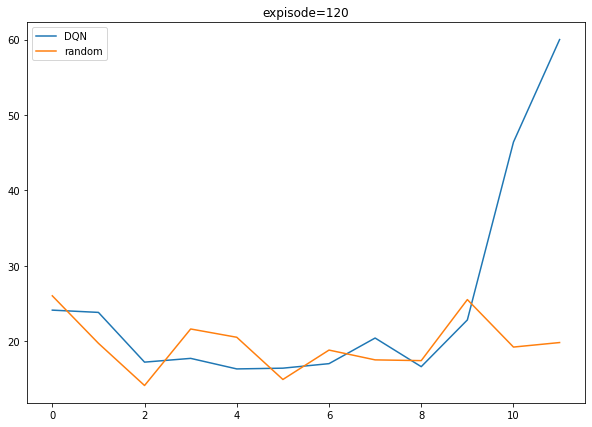

In [ ]:
### for visualization
# for deep q-learning
mean_score_dqn = []
score_dqn = 0
# for random action
mean_score_random = []
score_random = 0
# visualize the mean score of each plot_n steps
plot_n = 10
batch_size = 100
plt.figure(figsize=(10, 7))
for episode in range(M):
    state_dqn = env.reset() 
    for time in range(T):
        env.render()      # show the amination
        action = act(state_dqn)     # chose action
        next_state, reward, terminal, _ = env.step(action) # get feedback
        reward = 5 if not terminal else -5  # get -10 reward if fail
        memory = remember(memory, state_dqn, action, reward, next_state, terminal) # store transition
        state_dqn = next_state
        if len(memory) > batch_size and time % 5 == 0: # train q_model
            q_model = replay(memory, q_model, batch_size)
        if terminal:                
            print("episode: {}/{}, score: {}, epsilon: {:.2}"
                  .format(episode, M, time, epsilon), file=open('./log.txt', 'a'))
            break
    score_dqn += time
    # random action
    state_random = env.reset()
    for time in range(500):
        action = random.randint(0, action_size-1)
        next_state, _, terminal, _ = env.step(action) # get feedback
        state_random = next_state
        if terminal:                
            break
    score_random += time
    if (episode+1) % plot_n == 0:
        display.clear_output()
        plt.clf()
        mean_score_dqn.append(score_dqn / plot_n)
        mean_score_random.append(score_random / plot_n)
        score_dqn = 0
        score_random = 0
        plt.title('expisode={}'.format(episode+1))
        plt.plot(mean_score_dqn, label="DQN")
        plt.plot(mean_score_random, label="random")
        plt.legend()
        display.display(plt.gcf())
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

### Analytical questions
**Q3. Explain the role of exploration rate.**